# Autoencoder Cuello de botella


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os


In [ ]:
# Cargamos la base de imagenes mnist

input_shape = (64, 64, 1)  # Tamaño de las imágenes

model_path = "autoencoder_model.keras"  # Nombre del archivo del modelo guardado

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train.astype("float32") / 255.0, axis=-1)
x_test = np.expand_dims(x_test.astype("float32") / 255.0, axis=-1)
x_train = tf.image.resize(x_train, (64 ,64))
x_test = tf.image.resize(x_test, (64 ,64))

In [ ]:
@tf.keras.utils.register_keras_serializable()
# funcion para tapar las neuronas que sean muy cercanas a cero, asi mismo la podemos ocupar para modificarla entrada del decoder
class Mask(keras.layers.Layer):
    def call(self,inputs):
      mask = tf.cast(tf.abs(inputs) > 1e-6, tf.float32)  # 1 si |z| > umbral, 0 si no
      return inputs * mask  # Se eliminan valores cercanos a 0


In [ ]:
latent_dim = 64
encoder_inputs = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)

z_masked = Mask(name="z_masked")(z_mean)  # Aplicar máscara

encoder = keras.Model(encoder_inputs, z_masked, name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      33,554,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ z_mean (Dense)                       │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ z_masked (Mask)                      │ (None, 64)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,600,384 (128.18 MB)

 Trainable params: 33,600,384 (128.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))

z_modified = Mask(name="z_modified")(latent_inputs)  # Aplicar filtro

x = layers.Dense(64 * 64 * 64, activation="relu")(z_modified)
x = layers.Reshape((64, 64, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=1, padding="same")(x)
#x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)  # Salida

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ z_modified (Mask)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 262144)              │      17,039,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,076,865 (65.14 MB)

 Trainable params: 17,076,865 (65.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#AE y su train_step()
class AE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape(persistent=True) as tape:
            z = self.encoder(data)

            reconstruction = decoder(z)
            #reconstruction = tape.gradient(reconstruction,z)
            L1 = tf.norm(z, ord=1) #Norma L1 actuando sobre la salida del encoder

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            total_loss = reconstruction_loss + L1

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
              }

In [ ]:
ae = AE(encoder, decoder)
ae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001 )) #, run_eagerly=True)
ae.fit(x_train, epochs=100, batch_size=2*128)

encoder.save("encoder_L1.h5")
decoder.save("decoder_L1.h5")

dir = "/content/drive/MyDrive/Colab Notebooks/"
encoder.save(dir + "encoder_L1.keras")
decoder.save(dir + "decoder_L1.keras")

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 60s 195ms/step - reconstruction_loss: 2521.7065 - total_loss: 2570.8435
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 63s 166ms/step - reconstruction_loss: 1149.2615 - total_loss: 1149.4110
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - reconstruction_loss: 1094.4590 - total_loss: 1094.5809
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - reconstruction_loss: 1089.6837 - total_loss: 1089.8180
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - reconstruction_loss: 1086.9283 - total_loss: 1087.0437
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - reconstruction_loss: 1085.9153 - total_loss: 1086.0332
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 39s 164ms/step - reconstruction_loss: 1086.8030 - total_loss: 1086.9268
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - reconstruction_loss: 1086.8949 - total_loss: 1087.0106
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - reconstruction_loss: 1084.6383 - total

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


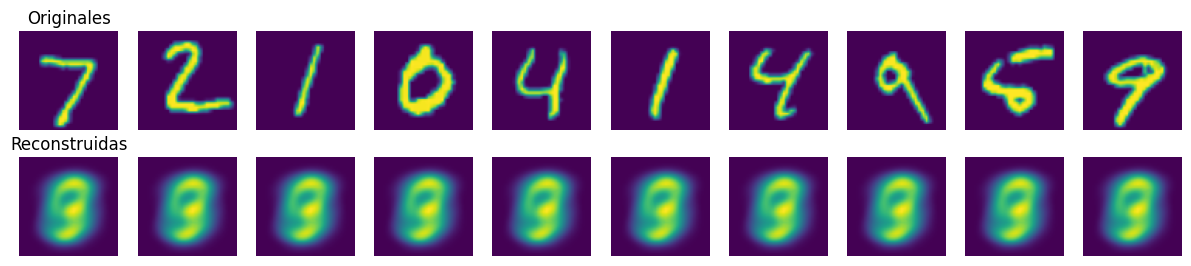

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model

dir = "/content/drive/MyDrive/Colab Notebooks/"
encoder = load_model(dir + 'encoder_L1.keras')
decoder = load_model(dir + 'decoder_L1.keras')

encoder_imgs = encoder.predict(x_test[:10])
decoded_imgs = decoder.predict(encoder_imgs)


fig, axes = plt.subplots(2, 10, figsize=(15, 3))

for i in range(10):
    axes[0, i].imshow(x_test[i])
    axes[0, i].axis("off")

    axes[1, i].imshow(decoded_imgs[i])
    axes[1, i].axis("off")

axes[0, 0].set_title("Originales")
axes[1, 0].set_title("Reconstruidas")
plt.show()